In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Crank Nicolson Finite Difference Method ###

The Black-Scholes PDE in terms of $x=\ln{S}$ is
$$
-\frac{\partial C}{\partial t} = \frac{1}{2}\sigma^{2}\frac{\partial^{2} C}{\partial x^{2}} + \nu\frac{\partial C}{\partial x} - rC
$$

where $\nu=r-d-\frac{1}{2}\sigma^{2}$

Different options are defined by their boundary conditions.

The Crank Nicolson FDM approximation of the Black-Scholes PDE is fully-centered approximation, with space and time derivatives approximated with finite diffences centred at time $i+\frac{1}{2}$
$$
-\frac{C_{i+1,j}-C_{i,j}}{\Delta_{x}} = \frac{1}{2}\sigma^{2}\frac{(C_{i+1,j+1} - 2C_{i+1,j} + C_{i+1,j-1}) + (C_{i,j+1} - 2C_{i,j} + C_{i,j-1})}{2\Delta_{x}^{2}} + 
    \nu\frac{(C_{i+1,j+1} - C_{i+1,j-1}) + (C_{i,j+1} - C_{i,j-1})}{4\Delta_{x}} - 
        r\frac{C_{i+1,j} + C_{i,j}}{2}
$$

which can be rewritten as
$$
p_{u}C_{i,j+1} + p_{m}C_{i,j} + p_{d}C_{i,j-1} = -p_{u}C_{i+1,j+1} - (p_{m}-2)C_{i+1,j} - p_{d}C_{i+1,j-1}\\
p_{u} = -\frac{1}{4}\Delta_{t}(\frac{\sigma^{2}}{\Delta_{x}^{2}} + \frac{\nu}{\Delta_{x}})\\
p_{m} = 1 + \Delta_{t}\frac{\sigma^{2}}{2\Delta_{x}^{2}} + \frac{r\Delta_{t}}{2}\\
p_{d} = -\frac{1}{4}\Delta_{t}(\frac{\sigma^{2}}{\Delta_{x}^{2}} - \frac{\nu}{\Delta_{x}})
$$

<center><img src='extra_files/FDMgrid.png' width='300' height='300'></center>

The boundary condition for the option price $C$ at $t=T$ is the value of the option at maturity.

The boundary conditions at large and small asset prices is determined by the behavoiur of the option price as $S \to \infty$ and $S \to 0$ respectively i.e.,

$$
C_{i,N_{j}} - C_{i,N_{j}-1} = \lambda_{U}\\
C_{i,-N_{j}+1} - C_{i,-N_{j}} = \lambda_{L}
$$

This translates to solving at each time index $i$, the set of $2N_{j}+1$ simultaneous linear equations for the option prices $[C_{i,N_{j}}, C_{i,N_{j}-1}, \cdots, C_{i,N_{-j+1}}, C_{i,N_{-j}}]$ as represented below

$$
\begin{bmatrix}
1 &-1 &0 &\cdots &\cdots &\cdots &0\\
p_{u} &p_{m} &p_{d} &0 &\cdots &\cdots &0\\
0 &p_{u} &p_{m} &p_{d} &0 &\cdots &0\\
\cdots &\cdots &\cdots &\cdots &\cdots &\cdots &\cdots\\
0 &\cdots &0 &p_{u} &p_{m} &p_{d} &0\\
0 &\cdots  &\cdots &0 &p_{u} &p_{m} &p_{d}\\
0 &\cdots &\cdots &\cdots &0 &1 &-1
\end{bmatrix}

\begin{bmatrix}
C_{i,N_{j}}\\
C_{i,N_{j}-1}\\
C_{i,N_{j}-2}\\
\cdots\\
C_{i,-N_{j}+2}\\
C_{i,-N_{j}+1}\\
C_{i,-N_{j}}
\end{bmatrix}

=

\begin{bmatrix}
1 &0 &0 &\cdots &\cdots &\cdots &\cdots &0\\
0 &-p_{u} &-(p_{m}-2) &-p_{d} &0 &\cdots &\cdots &0\\
0 &0 &-p_{u} &-(p_{m}-2) &-p_{d} &0 &\cdots &0\\
\cdots &\cdots &\cdots &\cdots &\cdots &\cdots &\cdots &\cdots\\
0 &\cdots &0 &-p_{u} &-(p_{m}-2) &-p_{d} &0 &0\\
0 &\cdots &\cdots &0 &-p_{u} &-(p_{m}-2) &-p_{d} &0\\
0 &\cdots &\cdots &\cdots &\cdots &0 &0 &1
\end{bmatrix}

\begin{bmatrix}
\lambda_{U}\\
C_{i+1,N_{j}}\\
C_{i+1,N_{j}-1}\\
C_{i+1,N_{j}-2}\\
\cdots\\
C_{i+1,-N_{j}+2}\\
C_{i+1,-N_{j}+1}\\
C_{i+1,-N_{j}}\\
\lambda_{L}
\end{bmatrix}
$$

The above system of equations, often called a tridiagonal system of equations, can be solved very efficiently. 

The Crank Nicolson method  is unconditionally stable and convergent, however the model parameters $p_{u}$, $p_{m}$ and $p_{d}$ can assume values greater than 1 and less than 0 and thus can no longer be interpreted as probabilities.

In [43]:
def CN_Euro(S0: float, K: float, r: float, sigma: float, div: float, T: float, Ntree: int, NS: int, optype: str) -> list:
    '''
    S0: initial asset price
    K: strike price
    r: risk-free rate
    sigma: volatility
    div: continuous dividend yeild
    T: time to maturity
    Ntree: number of time steps to maturity
    NS: size of stock price grid on either side of S0
    optype: option type ('call' or 'put')
    '''

    dt = T/Ntree
    Srange = 2*3.5*sigma*np.sqrt(T) # hard coded (reasonable) range of asset prices at maturity
    dx = Srange/(2*NS) # grid spacing in asset price
    nu = (r-div)-0.5*sigma**2
    sf = dt*(sigma/dx)**2
    af = dt*nu/dx

    # FDM_CN probabilities
    pu = -0.25*(sf + af)
    pm = 1 + 0.5*(sf + r*dt)
    pd = -0.25*(sf - af)

    # constant probability matrix A
    pu_A = np.pad(pu*np.ones(2*NS-1), pad_width=(0,1), mode='constant', constant_values=(0,1))
    pm_A = np.pad(pm*np.ones(2*NS-1), pad_width=(1,1), mode='constant', constant_values=(1,-1))
    pd_A = np.pad(pd*np.ones(2*NS-1), pad_width=(1,0), mode='constant', constant_values=(-1,0))
    matA = np.diag(pu_A, k=-1) + np.diag(pm_A, k=0) + np.diag(pd_A, k=1)
    
    # constant probability matrix B
    pu_B = np.pad(-pu*np.ones(2*NS-1), pad_width=(0,1), mode='constant', constant_values=(0,0))
    pm_B = np.pad(-(pm-2)*np.ones(2*NS-1), pad_width=(1,1), mode='constant', constant_values=(0,0))
    pd_B = np.pad(-pd*np.ones(2*NS-1), pad_width=(1,0), mode='constant', constant_values=(0,0))
    matB = np.diag(pu_B, k=-1) + np.diag(pm_B, k=0) + np.diag(pd_B, k=1)
    unit_col = np.append(1, np.zeros(2*NS)).reshape(-1,1)
    matB = np.hstack((unit_col, matB, unit_col[::-1]))

    # parameter exception
    if ((0<r) and (0<sigma)):
        pass
    else:
        raise Exception('parameter values not allowed')
    
    #payoff array
    j0 = NS # centre index
    exponents = np.arange(-NS, NS+1)
    Sarr = S0*np.exp(dx*exponents[::-1]) # asset price array
    Karr = K*np.ones(2*NS+1) #strike
    Parr = Sarr - Karr # payoff

    if optype == 'call':
        Parr[Parr<0] = 0
        Parr = Parr
    elif optype == 'put':
        Parr[Parr>0] = 0
        Parr = -Parr
    else: raise Exception('optype must be call or put')

    # payoff at maturity T
    Vmat = np.zeros(shape=(2*NS+1,Ntree+1)) # 2*NS x Ntree matrix
    Vmat[:,-1] = Parr

    # backward step wise option price calculation
    if optype == 'call':
        for t in range(Ntree-1,-1,-1):
            lu = Sarr[0] - Sarr[1] # call b.c. for large S
            ld = 0 # call b.c. for small S
            Tarr = np.pad(Vmat[:,t+1], pad_width=(1,1), mode='constant', constant_values=(lu,ld))
            Varr = np.linalg.solve(matA, np.matmul(matB,Tarr)) # solve s.l.e.
            Varr = np.clip(Varr, a_min=0, a_max=None)
            Vmat[:,t] = Varr
    if optype == 'put':
        for t in range(Ntree-1,-1,-1):
            lu = 0 # call b.c. for large S
            ld = Sarr[-2] - Sarr[-1] # call b.c. for small S
            Tarr = np.pad(Vmat[:,t+1], pad_width=(1,1), mode='constant', constant_values=(lu,ld))
            Varr = np.linalg.solve(matA, np.matmul(matB,Tarr)) # solve s.l.e.
            Varr = np.clip(Varr, a_min=0, a_max=None)
            Vmat[:,t] = Varr           

    return(Vmat)

In [49]:
j0=15
price=CN_Euro(S0=100, K=100, r=0.06, sigma=0.2, div=0.01, T=1, Ntree=5, NS=j0, optype='put')
print(np.round(price[j0,0], 3))

5.498


In [46]:
def CN_Amer(S0: float, K: float, r: float, sigma: float, div: float, T: float, Ntree: int, NS: int, optype: str) -> list:
    '''
    S0: initial asset price
    K: strike price
    r: risk-free rate
    sigma: volatility
    div: continuous dividend yeild
    T: time to maturity
    Ntree: number of time steps to maturity
    NS: size of stock price grid on either side of S0
    optype: option type ('call' or 'put')
    '''

    dt = T/Ntree
    Srange = 2*3.5*sigma*np.sqrt(T) # hard coded (reasonable) range of asset prices at maturity
    dx = Srange/(2*NS) # grid spacing in asset price
    nu = (r-div)-0.5*sigma**2
    sf = dt*(sigma/dx)**2
    af = dt*nu/dx

    # FDM_CN probabilities
    pu = -0.25*(sf + af)
    pm = 1 + 0.5*(sf + r*dt)
    pd = -0.25*(sf - af)

    # constant probability matrix A
    pu_A = np.pad(pu*np.ones(2*NS-1), pad_width=(0,1), mode='constant', constant_values=(0,1))
    pm_A = np.pad(pm*np.ones(2*NS-1), pad_width=(1,1), mode='constant', constant_values=(1,-1))
    pd_A = np.pad(pd*np.ones(2*NS-1), pad_width=(1,0), mode='constant', constant_values=(-1,0))
    matA = np.diag(pu_A, k=-1) + np.diag(pm_A, k=0) + np.diag(pd_A, k=1)
    
    # constant probability matrix B
    pu_B = np.pad(-pu*np.ones(2*NS-1), pad_width=(0,1), mode='constant', constant_values=(0,0))
    pm_B = np.pad(-(pm-2)*np.ones(2*NS-1), pad_width=(1,1), mode='constant', constant_values=(0,0))
    pd_B = np.pad(-pd*np.ones(2*NS-1), pad_width=(1,0), mode='constant', constant_values=(0,0))
    matB = np.diag(pu_B, k=-1) + np.diag(pm_B, k=0) + np.diag(pd_B, k=1)
    unit_col = np.append(1, np.zeros(2*NS)).reshape(-1,1)
    matB = np.hstack((unit_col, matB, unit_col[::-1]))

    # parameter exception
    if ((0<r) and (0<sigma)):
        pass
    else:
        raise Exception('parameter values not allowed')
    
    #payoff array
    j0 = NS # centre index
    exponents = np.arange(-NS, NS+1)
    Sarr = S0*np.exp(dx*exponents[::-1]) # asset price array
    Karr = K*np.ones(2*NS+1) #strike
    Parr = Sarr - Karr # payoff

    if optype == 'call':
        Parr[Parr<0] = 0
        Parr = Parr
    elif optype == 'put':
        Parr[Parr>0] = 0
        Parr = -Parr
    else: raise Exception('optype must be call or put')

    # payoff at maturity T
    Vmat = np.zeros(shape=(2*NS+1,Ntree+1)) # 2*NS x Ntree matrix
    Vmat[:,-1] = Parr

    # backward step wise option price calculation
    if optype == 'call':
        for t in range(Ntree-1,-1,-1):
            lu = Sarr[0] - Sarr[1] # call b.c. for large S
            ld = 0 # call b.c. for small S
            Tarr = np.pad(Vmat[:,t+1], pad_width=(1,1), mode='constant', constant_values=(lu,ld))
            Varr = np.linalg.solve(matA, np.matmul(matB,Tarr)) # solve s.l.e.
            Varr = np.clip(Varr, a_min=0, a_max=None)
            Varr = np.maximum(Varr, Parr) # American option
            Vmat[:,t] = Varr
    if optype == 'put':
        for t in range(Ntree-1,-1,-1):
            lu = 0 # call b.c. for large S
            ld = Sarr[-2] - Sarr[-1] # call b.c. for small S
            Tarr = np.pad(Vmat[:,t+1], pad_width=(1,1), mode='constant', constant_values=(lu,ld))
            Varr = np.linalg.solve(matA, np.matmul(matB,Tarr)) # solve s.l.e.
            Varr = np.clip(Varr, a_min=0, a_max=None)
            Varr = np.maximum(Varr, Parr) # American option
            Vmat[:,t] = Varr           

    return(Vmat)

In [48]:
j0=15
price=CN_Amer(S0=100, K=100, r=0.06, sigma=0.2, div=0.01, T=1, Ntree=5, NS=j0, optype='put')
print(np.round(price[j0,0], 3))

5.949


In [59]:
# price convergence (both in time and stock price steps)

# calculate parameters
S0=100
K=90
r=0.06
sigma=0.2
div=0.03
T=1

Nsteps=np.logspace(1,2.5,10).astype(int) # steps sizes

Ecall_price_array=[]
Acall_price_array=[]
Eput_price_array=[]
Aput_price_array=[]

for nstep in Nsteps:
    #European
    price=CN_Euro(S0=S0, K=K, r=r, sigma=sigma, div=div, T=T, Ntree=nstep, NS=nstep, optype='call')
    Ecall_price_array.append(price[nstep,0])
    price=CN_Euro(S0=S0, K=K, r=r, sigma=sigma, div=div, T=T, Ntree=nstep, NS=nstep, optype='put')
    Eput_price_array.append(price[nstep,0])
    #American
    price=CN_Amer(S0=S0, K=K, r=r, sigma=sigma, div=div, T=T, Ntree=nstep, NS=nstep, optype='call')
    Acall_price_array.append(price[nstep,0])
    price=CN_Amer(S0=S0, K=K, r=r, sigma=sigma, div=div, T=T, Ntree=nstep, NS=nstep, optype='put')
    Aput_price_array.append(price[nstep,0])

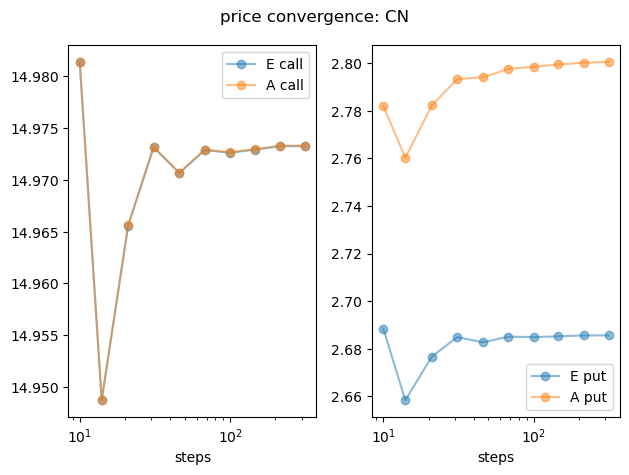

In [60]:
# plot convergence
fig,ax=plt.subplots(1,2)
ax[0].semilogx(Nsteps,Ecall_price_array, 'o-', alpha=0.5, label='E call')
ax[0].semilogx(Nsteps,Acall_price_array, 'o-', alpha=0.5, label='A call')
ax[0].set_xlabel('steps')
ax[0].legend()

ax[1].semilogx(Nsteps,Eput_price_array, 'o-', alpha=0.5, label='E put')
ax[1].semilogx(Nsteps,Aput_price_array, 'o-', alpha=0.5, label='A put')
ax[1].set_xlabel('steps')
ax[1].legend()

plt.suptitle('price convergence: CN')
plt.tight_layout()